In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist



In [2]:
def build_generator(img_size, latent_dim):
    z = Input(shape = (latent_dim))
    x = Dense(128, activation = tf.nn.leaky_relu)(z)
    x = Dense(256, activation = tf.nn.leaky_relu)(x)
    x = Dense(512, activation = tf.nn.leaky_relu)(x)
    x = Dense(1024, activation = tf.nn.leaky_relu)(x)
    x = Dense(img_size)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(shape = (img_size))
    z = Dense(1024, activation = tf.nn.leaky_relu)(x)
    z = Dense(512, activation = tf.nn.leaky_relu)(z)
    z = Dense(256, activation = tf.nn.leaky_relu)(z)
    z = Dense(128, activation = tf.nn.leaky_relu)(z)
    z = Dense(latent_dim)(z)
    return Model(x, z)

def build_discriminator(img_size, latent_dim):
    x = Input(shape=(img_size))
    z = Input(shape=(latent_dim))
    y = Concatenate()([x,z])
    y = Dense(1024, activation = tf.nn.leaky_relu)(y)
    y = Dense(512, activation = tf.nn.leaky_relu)(y)
    y = Dense(256, activation = tf.nn.leaky_relu)(y)
    y = Dense(128, activation = tf.nn.leaky_relu)(y)
    y = Dense(1)(y)
    return Model([x,z], y)


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num = X_train.shape[0]

X_train = (X_train.reshape(num,-1)/255.0)*2 - 1
X_test = (X_test.reshape(X_test.shape[0],-1)/255.0)*2 - 1

In [4]:
latent_dim = 100
img_dim = X_train.shape[1]

enc = build_encoder(img_dim, latent_dim)
gen = build_generator(img_dim, latent_dim)
disc = build_discriminator(img_dim, latent_dim)

g_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
e_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
d_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)

epochs = 100
batch_size = 128

Metal device set to: Apple M2


2023-03-20 21:23:09.493872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-20 21:23:09.493965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
z_train = np.random.uniform(-1,1, (num, latent_dim))

In [6]:
for epoch in tqdm(range(epochs), desc='Total'):
    perm = np.random.permutation(num)
    
    X_train = X_train[perm]
    y_train = y_train[perm]
    z_train = z_train[perm]
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    for steps in range(0, num_steps):
        x_batch = X_train[batch_size*(steps):batch_size*(steps+1)]
        z_batch = z_train[batch_size*(steps):batch_size*(steps+1)]
        y_batch = y_train[batch_size*(steps):batch_size*(steps+1)]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)

            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(-pred_enc))
            disc_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen)) + tf.reduce_mean(tf.nn.softplus(pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))

Total:   0%|          | 0/100 [00:00<?, ?it/s]

[0] Desc loss : 519.8566544056	 Gen Loss : 381.9194992930	 Enc Loss : 843.7576610446
[1] Desc loss : 461.1479970515	 Gen Loss : 479.2651209235	 Enc Loss : 1169.6268230379
[2] Desc loss : 540.4711489379	 Gen Loss : 498.2472362071	 Enc Loss : 997.3185671270
[3] Desc loss : 580.1323111653	 Gen Loss : 521.2705540061	 Enc Loss : 856.6966605484
[4] Desc loss : 595.0297825336	 Gen Loss : 531.7996597141	 Enc Loss : 667.8194058239
[5] Desc loss : 559.1133378744	 Gen Loss : 550.2330547273	 Enc Loss : 726.5086404085
[6] Desc loss : 597.9422691464	 Gen Loss : 564.6103478521	 Enc Loss : 709.0123921335
[7] Desc loss : 603.6832119823	 Gen Loss : 512.6407214254	 Enc Loss : 531.6567438841
[8] Desc loss : 589.6344235837	 Gen Loss : 551.2910522223	 Enc Loss : 651.5079585314
[9] Desc loss : 564.3587270379	 Gen Loss : 522.9516268075	 Enc Loss : 634.6549416780
[10] Desc loss : 548.7988258004	 Gen Loss : 544.5110493302	 Enc Loss : 736.7913306952
[11] Desc loss : 540.5088359714	 Gen Loss : 569.1047838032	 Enc

[95] Desc loss : 265.5463889539	 Gen Loss : 1331.7172479630	 Enc Loss : 1540.4305061698
[96] Desc loss : 261.4438077658	 Gen Loss : 1350.6388018131	 Enc Loss : 1559.4216181040
[97] Desc loss : 257.2015613765	 Gen Loss : 1351.8209816217	 Enc Loss : 1562.3768274784
[98] Desc loss : 257.8615091741	 Gen Loss : 1373.3036140203	 Enc Loss : 1574.4906606674
[99] Desc loss : 253.0168502629	 Gen Loss : 1385.4954816103	 Enc Loss : 1599.3961915970


1/1 [==============================] - 0s 6ms/step


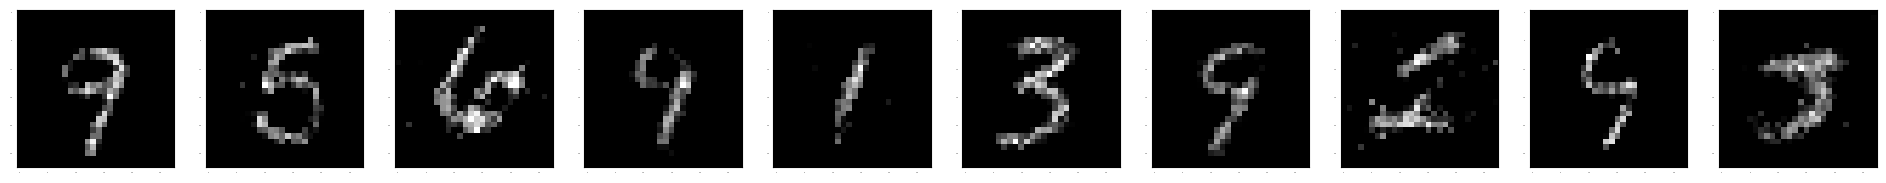

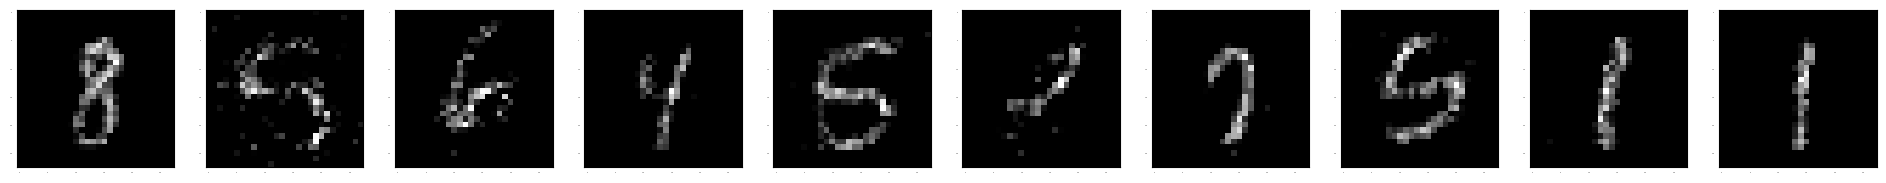

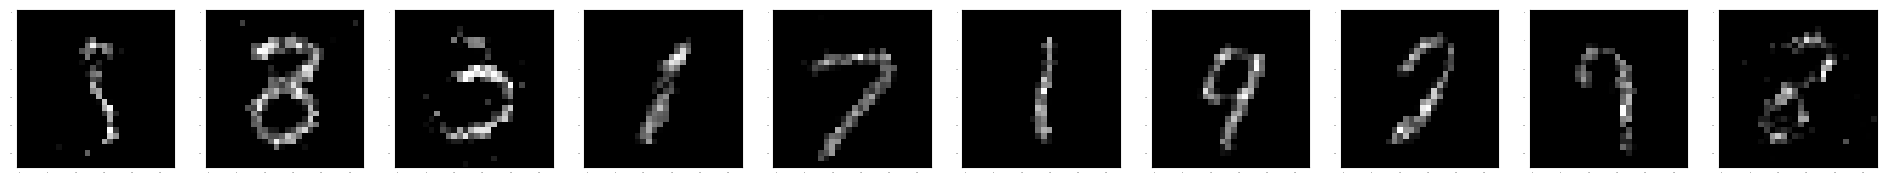

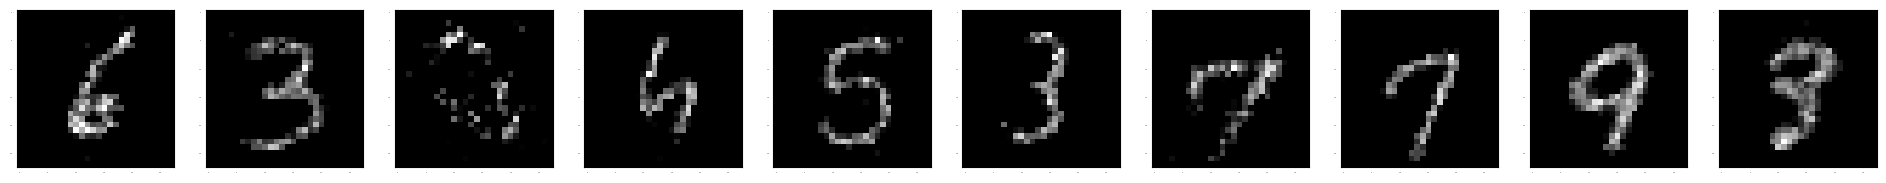

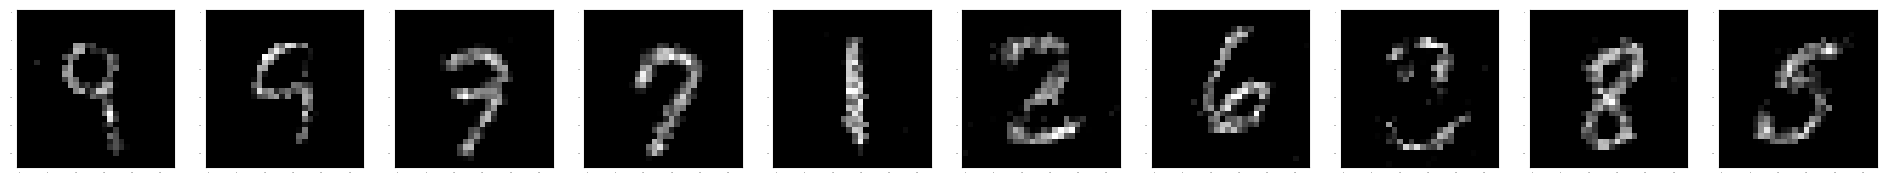

In [11]:
for _ in range(5):
    num_sample = 10
    z_test = np.random.uniform(-1,1, (num, latent_dim))
    pred = gen.predict(z_test[:num_sample]).reshape(-1,28,28)

    _, axs = plt.subplots(1,num_sample, figsize=(24,12))
    for i in range(num_sample):
        axs[i].imshow(np.clip((pred[i])*(255.0/2), 0, 255), cmap = 'gray')
        axs[i].tick_params(length=0, labelsize=0)